In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Demonstration of how to fit halo MAHs with the `diffstar` model

This notebook illustrates a worked example of how to fit an individual halo SFH with the diffstar model. For a parallelized script, see `history_fitting_script.py`.

## Load a block of target data


These data can be downloaded from the site hosting the project data. But in principle the fitting function should work with data from any sim.

In [2]:
from diffstar.data_loaders.load_smah_data import load_tng_data, load_fit_mah, LAPTOP

/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)


In [3]:
# This is the TNG simulation data.
halo_ids, log_smahs, sfrhs, tarr, dt = load_tng_data("cens", data_drn=LAPTOP)
# This is the best-fit diffmah parameters fit to each TNG halo.
mah_fit_params, logmp = load_fit_mah("run1_tng_diffmah", data_drn=LAPTOP)

## Pick a particular example galaxy history to fit


In [4]:
from diffstar.fit_smah_helpers import get_loss_data_default

itest = 0
itest = np.arange(len(logmp))[(logmp>13.0)&(logmp<13.1)][itest]

halo_id = halo_ids[itest]
lgsmah = log_smahs[itest]
sfrh = sfrhs[itest]
mah_params = mah_fit_params[itest]
logmp_halo = logmp[itest]

p_init, loss_data = get_loss_data_default(
    tarr, dt, sfrh, lgsmah, logmp_halo, mah_params
)

## Use L-BFGS-B to fit the SFH with the smooth model

In [28]:
from diffstar.fit_smah_helpers import loss_default, loss_grad_default_np
from diffstar.utils import minimizer_wrapper


_res = minimizer_wrapper(
    loss_default, loss_grad_default_np, p_init, loss_data, 
)
p_best, loss_best, success = _res

## Grab the unbounded values of the best-fit parameters


In [29]:
from diffstar.fit_smah_helpers import get_outline_default, get_header

outline = get_outline_default(halo_id, loss_data, p_best, loss_best, success)
header = get_header()

output_data = dict(zip(header[1:].strip().split(), outline.strip().split()))

colnames = list(output_data.keys())
sfr_colnames = colnames[1:6]
q_colnames = colnames[6:10]

u_sfr_fit_params = np.array([output_data[key] for key in sfr_colnames]).astype(float)
u_q_fit_params = np.array([output_data[key] for key in q_colnames]).astype(float)

output_data

{'halo_id': '1251',
 'lgmcrit': '1.15884e+01',
 'lgy_at_mcrit': '1.17262e-01',
 'indx_lo': '6.05819e-01',
 'indx_hi': '-7.67132e-01',
 'tau_dep': '-9.95171e+00',
 'qt': '1.06138e+00',
 'qs': '-4.43739e+00',
 'q_drop': '-1.09065e+00',
 'q_rejuv': '-4.21483e+00',
 'loss': '2.96707e-02',
 'success': '1'}

## Transform the unbounded parameters to the actual `diffstar` parameters


In [30]:
from diffstar.stars import _get_bounded_sfr_params
from diffstar.quenching import _get_bounded_q_params

sfr_fit_params = np.array(_get_bounded_sfr_params(*u_sfr_fit_params))
q_fit_params = np.array(_get_bounded_q_params(*u_q_fit_params))

## Calculate histories using the best-fit model


In [31]:
from diffstar.stars import calculate_sm_sfr_fstar_history_from_mah

dmhdt_fit, log_mah_fit = loss_data[2:4]
lgt = np.log10(tarr)
index_select, index_high, fstar_tdelay = loss_data[8:11]
    
_histories = calculate_sm_sfr_fstar_history_from_mah(
    lgt,
    dt,
    dmhdt_fit,
    log_mah_fit,
    u_sfr_fit_params,
    u_q_fit_params,
    index_select,
    index_high,
    fstar_tdelay,
)
smh_fit, sfh_fit, fstar_fit = _histories

## Compare the model to the simulated SFH


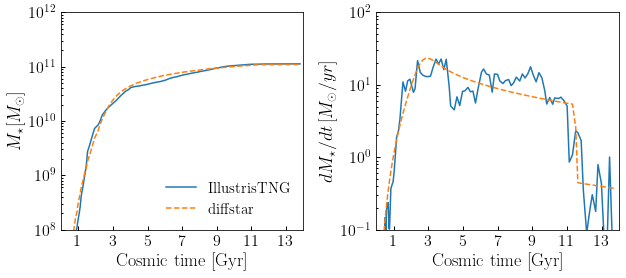

In [32]:
fig, ax = plt.subplots(1,2, figsize=(10,4), sharex=True)


ax[0].plot(tarr, 10**lgsmah, label='IllustrisTNG')
ax[0].plot(tarr, smh_fit, ls='--', label='diffstar')
ax[0].set_yscale('log')
ax[0].set_ylim(1e8, 1e12)
ax[0].set_xlim(0, 14)
ax[0].set_xlabel('Cosmic time [Gyr]')
ax[0].set_ylabel('$M_\star [M_{\odot}]$')
ax[0].legend(loc=4)

ax[1].plot(tarr, sfrh)
ax[1].plot(tarr, sfh_fit, ls='--')
ax[1].set_yscale('log')
ax[1].set_ylim(1e-1, 1e2)
ax[1].set_xlim(0, 14)
ax[1].set_xticks(np.arange(1,14,2))
ax[1].set_xlabel('Cosmic time [Gyr]')
ax[1].set_ylabel('$dM_\star/dt \,[M_{\odot}/yr]$')
fig.subplots_adjust(wspace=0.3)

plt.show()

## Show the model main sequence efficiency and quenching function

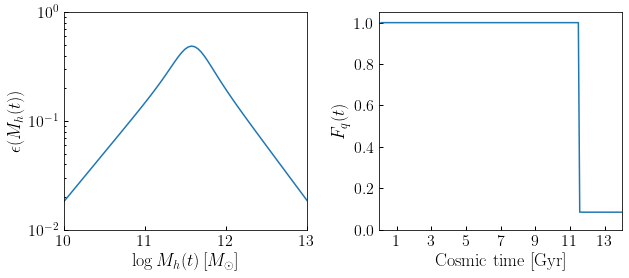

In [33]:
from diffstar.stars import _sfr_eff_plaw
from diffstar.quenching import quenching_function

_m = np.linspace(10, 14, 100)
MS_efficiency_fit = _sfr_eff_plaw(_m, *sfr_fit_params[:-1])
_t = np.linspace(-1,2,1000)
qf = quenching_function(_t, *u_q_fit_params)

fig, ax = plt.subplots(1,2, figsize=(10,4), sharex=False)


ax[0].plot(_m, MS_efficiency_fit)
ax[0].set_yscale('log')
ax[0].set_ylim(1e-2, 1e0)
ax[0].set_xlim(10, 13)
ax[0].set_xticks(np.arange(10,13.1,1.0))
ax[0].set_xlabel('$\log M_{h}(t) \, [M_{\odot}]$')
ax[0].set_ylabel('$\epsilon(M_{h}(t))$')

ax[1].plot(10**_t, qf)
ax[1].set_xlim(0, 14)
ax[1].set_ylim(0, 1.05)
ax[1].set_xticks(np.arange(1,14,2))
ax[1].set_xlabel('Cosmic time [Gyr]')
ax[1].set_ylabel('$F_q(t)$')
fig.subplots_adjust(wspace=0.3)
